## Take-home exam

#### David Landveld
#### 2742120

### Load modules

In [2]:
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from scipy.stats import norm
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
import numpy.random as npr
import time
import sqlite3 as sql
import seaborn as sns
import statsmodels.api as sm
import random
from numba import jit, prange
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon') 
sent = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Question 1

In this question the goal is to analyze the complaints dataset of JPMorgan Chase. I first prepare the data. Then complete the required tasks. 

To do list: 
     beschrijf wat ik gedaan heb 
     opmaak checken 
     
    

In [1791]:
# First I need to open the complaints dataset and only read 
#the rows with jpmorgan data. here I already use 'Date Received as an index'
complaints = pd.read_csv('complaints.csv.zip', 
                         parse_dates=['Date received'],
                         index_col= ['Date received'])

#Then I make sure to only grap the data of JPMorgan Chase.
complaints = complaints[complaints.Company == 'JPMORGAN CHASE & CO.']

# We also have to only keep the rows with date between 2013-01-01 and 
#2020-06-30

#To do this I first sort the dataframe by time form past to present.
complaints = complaints.sort_index()

#Then I assign the start and end date now. 
start_date = pd.to_datetime('2013-01-01')
end_date = pd.to_datetime('2020-06-30')

#Now I can edit the dataframe so that only the right dates are in the
#data set. 
complaints = complaints.loc[start_date:end_date]

# I replace all ' ' and '-' by '_' so that it is easier to call the 
#the columsn later. 
complaints.columns = complaints.columns.str.replace(' ','_')
complaints.columns = complaints.columns.str.replace('-','_')
complaints.index.name = 'Date_received'

### Task 1

Here I complete three subtasks where I need to compute quarterly values and display them.  

#### i. 

In [1792]:
#I need to create the columsn that show which quarter the data is in. 
#I first create a column for quarter with starting values 1. Then
# I use a for loop to fill them with a+1 number if it is a new quarter. 
complaints['quarter'] = 1
start_date1 = start_date
a = 1
for i in range(1,len(complaints)):
    if complaints.index[i].month%3 == 1 and complaints.index[i-1].month%3 != 1:
        a += 1
        complaints.quarter[i] = a
    else: 
        complaints.quarter[i] = a 

<ipython-input-1792-32d3d4466433>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints.quarter[i] = a
<ipython-input-1792-32d3d4466433>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints.quarter[i] = a


In [1793]:
#Now we need to create one column that marks if there is a complaint narrative. 

#first replace NaN by 0 because I need to be able to execute an if-statement to find out 
#Where to assign a '1' float number to count the amount of complaint narratives later. 
complaints.replace(np.NaN, 0, inplace=True)
complaints['c1icn'] = 0
for i in range(len(complaints)):
    if complaints.Consumer_complaint_narrative[i] != 0:
        complaints.c1icn[i] = 1
complaints.c1icn.replace(0, np.NaN, inplace=True)

<ipython-input-1793-4d0649243347>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints.c1icn[i] = 1


In [1794]:
#Now I can use groupby().sum() to count the amount of narratives. 
# I stored it and created a new dataframe.
qcc = complaints.c1icn.groupby(complaints.quarter).sum()
dfqcc = pd.DataFrame(qcc, columns=['c1icn'])
dfqcc.c1icn.replace(0, np.NaN, inplace=True)

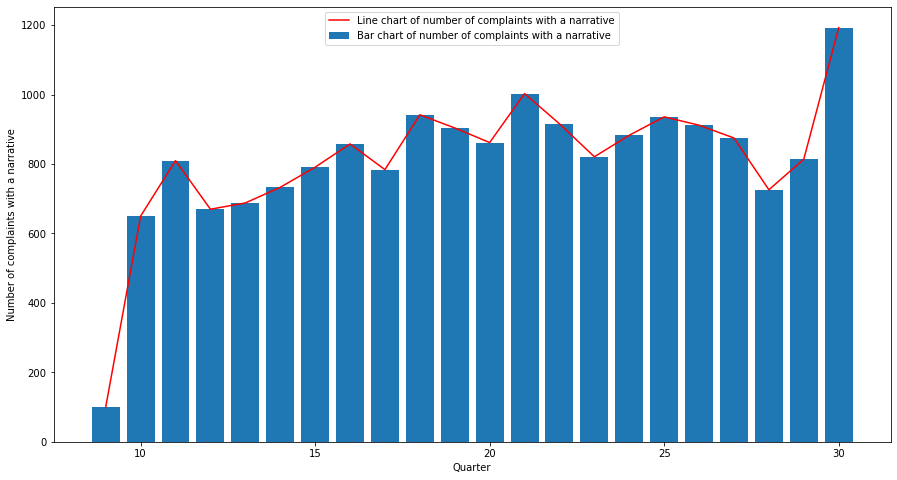

In [1795]:
#I can plot the dataframe. A bar and line chart will do just fine. 
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.bar(dfqcc.index,dfqcc.c1icn.values, 
       label='Bar chart of number of complaints with a narrative')
ax.plot(dfqcc.index,dfqcc.c1icn.values,
        color=('Red'),label=
        'Line chart of number of complaints with a narrative')
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of complaints with a narrative')
ax.legend()
plt.show()

So we see that the complaints shot up overall seem to be slightly increasing. There are some missing values for the first 9 quarters due to no records of complaint narratives. Lastly, we see a peak towards the end. 

#### ii. 


In [1796]:
#I create a complaints counter so that I can aggregate the total. 
complaints['tcomplaints']= 1

#Then I create a dataframe where I count the total complaints per quarter.
dfqcc['tcomplaints'] = complaints.tcomplaints.groupby(complaints.quarter).sum()

#Finally, I add the proporation of complaints without a narrative per quarter by first 
# making a column with empty float values and then filling them with a for loop. 
dfqcc['prop'] = 0.0
for i in range(1,len(dfqcc)+1):
    dfqcc.prop[i] = 1.0-(dfqcc.c1icn[i]/(dfqcc.tcomplaints[i]))

<ipython-input-1796-0f09a24bd616>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfqcc.prop[i] = 1.0-(dfqcc.c1icn[i]/(dfqcc.tcomplaints[i]))


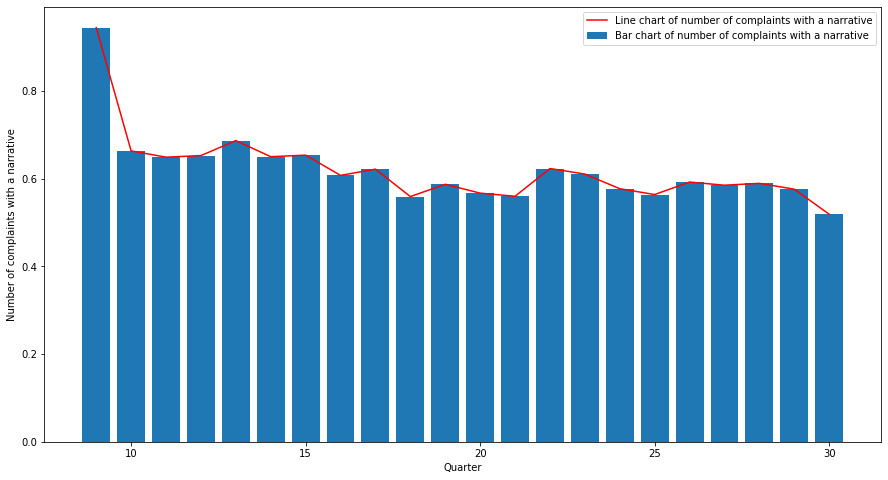

In [1797]:
#I can plot the dataframe. A bar and line chart will do just fine.
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.bar(dfqcc.index,dfqcc.prop.values, 
       label='Bar chart of number of complaints with a narrative')
ax.plot(dfqcc.index,dfqcc.prop.values,
        color=('Red'),label=
        'Line chart of number of complaints with a narrative')
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of complaints with a narrative')
ax.legend()
plt.show()

In the plot we see that the proportion of complaints without a narrative seems to decrease, which could hint that the narratives get lost or people stop writing out their complaints.
The beginning of the dataset does not show up in the figure because there were not values there, which would show a biased beginning.

#### iii.


In [1798]:
#Here i need to get the average and median compound sentiment scores.

#I first create a new column to store compound sentiment values in and fill the values
#by using a forloop. 
complaints['compoundsent'] = 0.0
for i in range(len(complaints)): 
    if complaints.Consumer_complaint_narrative[i] == 0.0:
        continue
    else: 
        complaints.compoundsent[i] = sent.polarity_scores(complaints.Consumer_complaint_narrative[i])['compound']

#I drop the 0.0000 values because otherwise data will get biased.
complaints.compoundsent.replace(0.000, np.NaN, inplace=True)

#Now I can compute and fill in the mean and median scores
dfqcc['meansent'] = complaints.compoundsent.groupby(complaints.quarter).mean()
dfqcc['mediansent'] = complaints.compoundsent.groupby(complaints.quarter).median()

<ipython-input-1798-a71afe260eca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints.compoundsent[i] = sent.polarity_scores(complaints.Consumer_complaint_narrative[i])['compound']


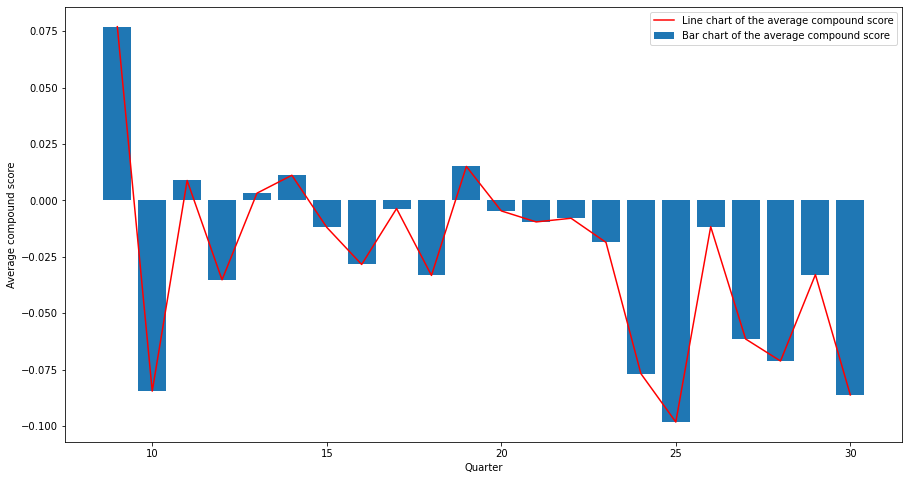

In [1803]:
#I first plot the mean compound sentiment scores.
#A bar and line chart will do just fine. 
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.bar(dfqcc.index,dfqcc.meansent.values, 
       label='Bar chart of the average compound score')
ax.plot(dfqcc.index,dfqcc.meansent.values,
        color=('Red'),label=
        'Line chart of the average compound score')
ax.set_xlabel('Quarter')
ax.set_ylabel('Average compound score')
ax.legend()
plt.show()

We see that the mean of the scores vary a lot. But I would say that they are mostly negative and more negative towards the end of the dataset.

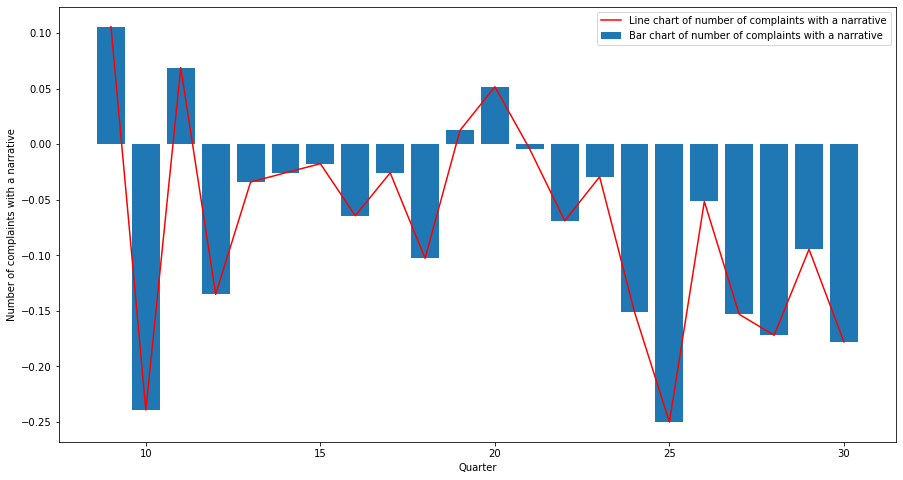

In [1806]:
#I can plot the median values now.
#A bar and line chart will do just fine.  
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.bar(dfqcc.index,dfqcc.mediansent.values, 
       label='Bar chart of number of complaints with a narrative')
ax.plot(dfqcc.index,dfqcc.mediansent.values,
        color=('Red'),label=
        'Line chart of number of complaints with a narrative')
ax.set_xlabel('Quarter')
ax.set_ylabel('Number of complaints with a narrative')
ax.legend()
plt.show()

We could interpret this figure in the same way as the previous one. Mostly shows negative scores and it gets worse at the end.

### Task 2

Here I need to aggregate the data on a monthly timeframe and run two regressions.

In [1808]:
#First I aggregate the montly average 


#I start by making a columns to order the months through values out of a for loop. 
complaints['month'] = 0
months = 1
for i in range(1,len(complaints)):
    if complaints.index[i].month != complaints.index[i-1].month:
        months+= 1
        complaints.month[i] = months
    else: 
        complaints.month[i] = months

<ipython-input-1808-49118b44995c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints.month[i] = months
<ipython-input-1808-49118b44995c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints.month[i] = months


In [1809]:
#Now I create a dataframe with the monthly data. 
dfmm = complaints.compoundsent.groupby(complaints.month).mean()
dfmm = pd.DataFrame(dfmm, columns=['compoundsent'])

dfmm = dfmm.iloc[1:] #I assume it is alright to drop the first row, since there is no data in that rows anyways.
#By dropping the first row, I create equal lenght of datasets.
#And finally I reset the index to match them with the crsp and ffmom datasets.
dfmm = dfmm.reset_index()

In [1810]:
#I read and open the crsp data.
crsp = pd.read_csv("crsp.csv")
#The dataset is complete so there is no need to clean it. 

In [1811]:
#I read and open the crsp data.
ffmom = pd.read_csv("ffmom.csv")
#Then I make sure to rename the date name to make it easier to merge them.
ffmom.rename(columns={'dateff': 'date'}, inplace=True) 
#The dataset is complete so there is no need to clean it. 

In [1812]:
#Merge with WRDS and ffmom dataset
data = pd.merge(dfmm,crsp,left_index=True, right_index=True)
data = pd.merge(data, ffmom,left_on="date",right_on="date")

#Then I can create an empty float values column and I fill the values with the excess returns
#by using a for loop.
data['Excess_ret']=0.0
for i in range(len(data)):
    data.Excess_ret[i]= data.RET[i] - data.rf[i]

<ipython-input-1812-64e238e1b13a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Excess_ret[i]= data.RET[i] - data.rf[i]


In [1831]:
#Run regression of the Fama and French model and display the results.
reg = ols("Excess_ret ~ mktrf + hml + smb + umd",data)
reg_results = reg.fit()
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Excess_ret   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     54.88
Date:                Wed, 20 Oct 2021   Prob (F-statistic):           8.85e-23
Time:                        18:09:44   Log-Likelihood:                 177.34
No. Observations:                  90   AIC:                            -344.7
Df Residuals:                      85   BIC:                            -332.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0066      0.004      1.660      0.101      -0.001       0.014
mktrf          1.0739      0.106     10.137      0.000       0.863       1.285
hml            1.1159      0.155      7.185      0.000       0.807       1.425
smb           -0.1027      0.164     -0.625      0.533      -0.429       0.224
umd            0.1852      0.138      1.341      0.184      -0.089       0.460
==============================================================================
Omnibus:                        1.376   Durbin-Watson:                   2.264
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.817
Skew:                           0.107   Prob(JB):                        0.665
Kurtosis:                       3.415   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficients are mostly signficant, meaning that we can use the residuals to compute the next regression

In [1814]:
#To run the next regression I first create two new columns for the residuals and the 
#compoundscores lagged with t-1.
#I store the residuals in the column with a for loop.
data['residuals_reg'] = 0.0
data['compoundsentlag'] = 0.0
for i in range(len(data)):
    data.residuals_reg[i] = reg_results.resid[i]
    if i > 0:
        data.compoundsentlag[i] = data.compoundsent[i-1]
    else: 
        data.compoundsentlag[i] = data.compoundsent[i]

<ipython-input-1814-83793d57fe46>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.residuals_reg[i] = reg_results.resid[i]
<ipython-input-1814-83793d57fe46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.compoundsentlag[i] = data.compoundsent[i]
<ipython-input-1814-83793d57fe46>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.compoundsentlag[i] = data.compoundsent[i-1]


In [1815]:
#Now I can do the residuals regression and display the results. 
reg2 = ols("residuals_reg ~ compoundsent + compoundsentlag",data)
reg2_results = reg2.fit()
reg2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          residuals_reg   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.068
Date:                Wed, 20 Oct 2021   Prob (F-statistic):              0.135
Time:                        17:55:17   Log-Likelihood:                 133.01
No. Observations:                  63   AIC:                            -260.0
Df Residuals:                      60   BIC:                            -253.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0030      0.005     -0.619      0.538      -0.013       0.007
compoundsent       -0.0783      0.076     -1.036      0.304      -0.229       0.073
compoundsentlag    -0.1211      0.073     -1.659      0.102      -0.267       0.025
==============================================================================
Omnibus:                        1.334   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.890
Skew:                           0.286   Prob(JB):                        0.641
Kurtosis:                       3.111   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The average compound score can help predict the residual from the four-factor model.
If the average compound score goes up by 1 point, the residuals decrease by -0.0783. 
But unfortunately the values are not significant so we cannot be sure about this conclusion.
Check if I have used the right residuals 

### Question 2

In this question I will simulate stock prices and call option prices.  

### 1a.

In [1817]:
#I create a function with for loops to calculate the stock prices. 

def price_paths_slow(n, m, T, v, S, r):
    
    #Computing the steps up and down.
    u = np.exp(v*np.sqrt(T/m))
    d = 1/u
    
    #probabiltiy of up and down.
    pu = (np.exp(r*(T/m))-d)/(u-d)
    pd = 1-pu
    
    #Create an empty matrix to store the prices in. 
    #do m+1 because of the Starting price. 
    prices_slow = np.zeros((m+1, n)) #m = timesteps n = paths.
 
    #Now we set the initial stock price on every first column.
    for i in range(0,n):
        prices_slow[0,i] = S 
    
    #I set the seed to 3011 so that the same plots will be created. 
    npr.seed(3011)
    #This for loop computes the amount of paths and its stock prices.
    for i in range(1,m+1):
        for k in range(n): 
            prices_slow[i,k] = prices_slow[i-1,k]*npr.choice([u,d],1, p=[pu,pd])
 
    return prices_slow
 


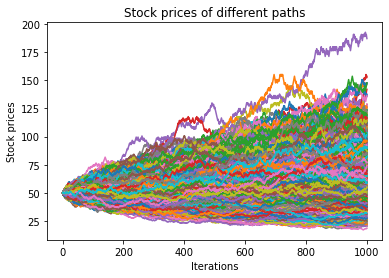

In [1818]:
#Now I can display the slow prices.
prices_slow = price_paths_slow(5000,1000, 2, 0.22, 50, 0.05)
plt.plot(prices_slow)
plt.title('Stock prices of different paths')
plt.xlabel('Iterations')
plt.ylabel('Stock prices')
plt.show()


In [1819]:
#Now I can compute the same prices but then in a faster way.
def price_paths_fast(n, m, T, v, S, r):
    #Computing the steps up and down.
    u = np.exp(v*np.sqrt(T/m))
    d = 1/u
    #probabiltiy of up and down.
    pu = (np.exp(r*(T/m))-d)/(u-d)
    pd = 1-pu
    #I set the seed to 3011 so that the same plots will be created. 
    npr.seed(3011)
    #The following sequence creates the prices.
    UD_series = npr.choice([u,d],m*n, replace=True,p=[pu,pd])
    UD_matrix = np.reshape(UD_series, (m,n))
    #I use cumprod because I want to know what the next price will be. 
    cumUDf = np.cumprod(UD_matrix,axis=0) 
    prices_fast = np.multiply((cumUDf),S)
    
    #Create the same startingpoints so that I can add them in the beginning 
    #of the prices_fast array. this will make sure every path begins at S.
    a1 = np.zeros((1,n))
    a2 = [S if x==0. else x for x in a1[0]]
    a1[0] = a2
    
    #append that startingpoint to the beginninng of prices_fast.
    a3 = np.append(a1, prices_fast, axis=0)
    prices_fast = a3
    return prices_fast

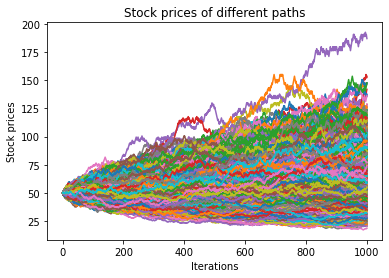

In [1820]:
#Now I can display the slow prices.
prices_fast = price_paths_fast(5000,1000, 2, 0.22, 50.0, 0.05)
plt.plot(prices_fast)
plt.title('Stock prices of different paths')
plt.xlabel('Iterations')
plt.ylabel('Stock prices')
plt.show()

### 1b.

In [1821]:
#Here I need to calculate the how long the functions will take to calculate the values of 
#the stock prices. 
def price_paths_slow(n, m, T, v, S, r):
    u = np.exp(v*np.sqrt(T/m))
    d = 1/u
    pu = (np.exp(r*(T/m))-d)/(u-d)
    pd = 1-pu
    prices_slow = np.zeros((m+1, n)) 
    for i in range(0,n):
        prices_slow[0,i] = S 
    npr.seed(3011)
    for i in range(1,m+1): 
        for k in range(n): 
            prices_slow[i,k] = prices_slow[i-1,k]*npr.choice([u,d],1, p=[pu,pd])
 
    return 

def price_paths_fast(n, m, T, v, S, r):
    u = np.exp(v*np.sqrt(T/m))
    d = 1/u
    pu = (np.exp(r*(T/m))-d)/(u-d)
    pd = 1-pu
    npr.seed(3011)
    UD_series = npr.choice([u,d],m*n, replace=True,p=[pu,pd])
    UD_matrix = np.reshape(UD_series, (m,n))
    cumUDf = np.cumprod(UD_matrix,axis=0)
    prices_fast = np.multiply((cumUDf),S)
    a1 = np.zeros((1,n))
    a2 = [S if x==0. else x for x in a1[0]]
    a1[0] = a2
    a3 = np.append(a1, prices_fast, axis=0)
    prices_fast = a3
    return
#After writing down both functions, i can make two list that will save the run times.
#The for loop will loop through the functions with the different iterations.
slow_times = []
fast_times = []
for i in range(0,4001,500):
    t0 = time.time()
    price_paths_slow(i,1000, 2, 0.22, 50.0, 0.05)
    t1 = time.time()
    slow_times.append(round(t1-t0, 2))
    t2 = time.time()
    price_paths_fast(i,1000, 2, 0.22, 50.0, 0.05)
    t3 = time.time()
    fast_times.append(round(t3-t2, 2))

In [1822]:
#Now I can create dataframes to store the run times in. 
dfst = pd.DataFrame(slow_times, columns = ['Slow_times'])
dfft = pd.DataFrame(fast_times, columns = ['Fast_times'])
#Merge them.
dfrt = pd.merge(dfst, dfft,left_index=True, right_index=True)
# I create an extra row that shows the iterations. Which I will use to set as an index.
dfrt['Iterations'] = 0
for i in range(len(dfrt)): 
    dfrt.Iterations[i] = i*500 
dfrt.set_index('Iterations')

<ipython-input-1822-a717e0c6c02e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrt.Iterations[i] = i*500


,Slow_times,Fast_times
Iterations,,
0,0.00,0.00
500,17.61,0.02
1000,35.42,0.04
1500,53.20,0.06
2000,69.52,0.08
2500,95.58,0.11
3000,108.41,0.15
3500,128.62,0.15
4000,150.13,0.17


In [1823]:
#Here I Create the new column for relative running time and fill it with a for loop.
dfrt['Relative_time']= 0.0
for i in range(len(dfrt)): 
    dfrt.Relative_time[i] = dfrt.Slow_times[i]/dfrt.Fast_times[i]

<ipython-input-1823-f41e14787b0b>:4: RuntimeWarning: invalid value encountered in double_scalars
  dfrt.Relative_time[i] = dfrt.Slow_times[i]/dfrt.Fast_times[i]
<ipython-input-1823-f41e14787b0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrt.Relative_time[i] = dfrt.Slow_times[i]/dfrt.Fast_times[i]


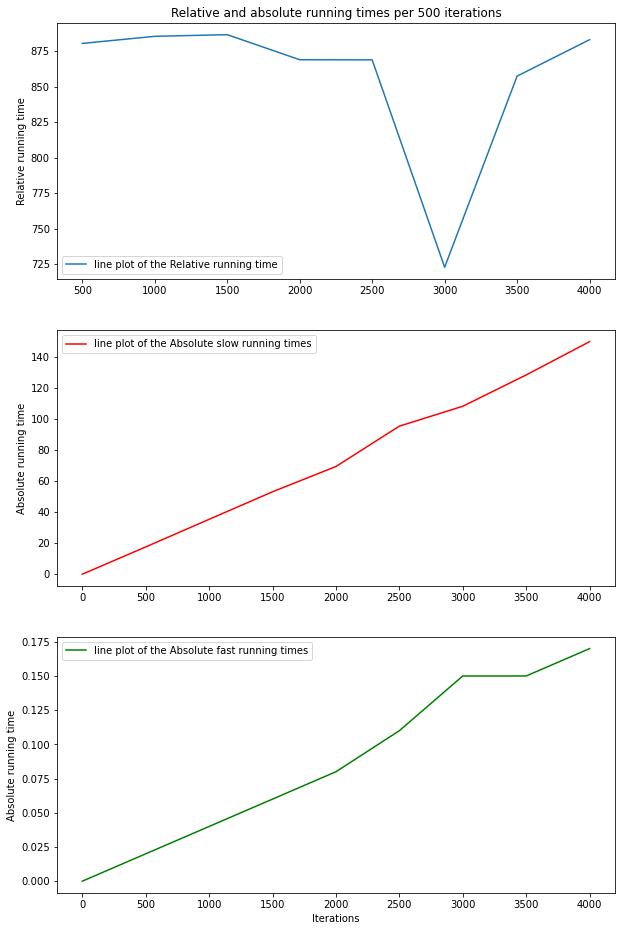

In [1824]:
#Now I can create the figure. I used three subfigures to show each individual plot.
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,16))
ax1.plot(dfrt.Iterations.values,dfrt.Relative_time.values, 
       label='line plot of the Relative running time')
ax2.plot(dfrt.Iterations.values,dfrt.Slow_times.values, color=('Red'),
       label='line plot of the Absolute slow running times')
ax3.plot(dfrt.Iterations.values,dfrt.Fast_times.values, color=('Green'),
       label='line plot of the Absolute fast running times')
ax1.set_title('Relative and absolute running times per 500 iterations')
ax3.set_xlabel('Iterations')
ax1.set_ylabel('Relative running time')
ax2.set_ylabel('Absolute running time')
ax3.set_ylabel('Absolute running time')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

We see that the relative running time is declining as there are more iterations. This is caused by a sharper increase in times at the end at the fast times than at the slow times. 

If we look at the absolute lines we can confirm this.

If we look at the changes we see that the slow running times increase linearly but deviate at 2500 iterations, but then convert back towards the average linear increase.

If we look at the absolute running times we see that they increase linearly until 2000 iterations, then the increases get bigger and at the end it increased exponentially. But this might convert back to the average increase if we would count more iterations.  

### 2

In [1825]:
#I Start with my fast model, we extend to use it to calculate the call price. 
#I also need to add what a variable input for the strike price as SP.
def call_options_price_fast(n, m, T, v, S, r, SP):
    u = np.exp(v*np.sqrt(T/m))
    d = 1/u
    pu = (np.exp(r*(T/m))-d)/(u-d)
    pd = 1-pu
    npr.seed(3011)
    UD_series = npr.choice([u,d],m*n, replace=True,p=[pu,pd])
    UD_matrix = np.reshape(UD_series, (m,n))
    cumUDf = np.cumprod(UD_matrix,axis=0)
    prices_fast = np.multiply((cumUDf),S)
    a1 = np.zeros((1,n))
    a2 = [S if x==0. else x for x in a1[0]]
    a1[0] = a2
    a3 = np.append(a1, prices_fast, axis=0)
    prices_fast = a3
    #Here I write down the sequence to determine the call options prices of my simulation.
    final_prices = prices_fast[m-1,:]
    call_price = final_prices - SP
    call_price[call_price < 0] = 0
    #Here I scale the time to match the rf rate. Use T/m.
    pv_call = call_price * np.exp(-r*T/m) 
    return np.mean(pv_call)

In [1826]:
#Now I create the call prices by the european call options model from the solution module on 
#canvas. 

#I also used a performance upgrade so that it would take less time to run. 
#I created functions and put ''@jit and nopython = True' above it
#for both parts that required loops and used those functions in the european call function.

@jit(nopython = True)
def stock_prices(s,u,d,m):
    for i in range(1,m+1):
        for j in range(0,i+1):
            if j == 0: # This is an up state
                s[j,i] = s[j,i-1]*u
            elif j > 0:
                s[j,i] = s[j-1,i-1]*d
    return s

@jit(nopython = True)
def call_price(c,p,m,r,dt):
    for i in range(m-1,-1,-1):
        for j in range(0,i+1):
                c[j,i] = (p*c[j,i+1]+(1-p)*c[j+1,i+1])*np.exp(-r*dt)
    return c

def european_call(S,T,m,r,SP,v):
    dt = T/m
    u = np.exp(v*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)
    s = np.zeros((m+1,m+1))
    c = np.zeros((m+1,m+1))
    s[0,0] = S
    s = stock_prices(s,u,d,m)
    c[:,m] = s[:,m] - SP
    c[c < 0] = 0
    c = call_price(c,p,m,r,dt)
    return c[0,0] 

In [1827]:
#This is the Black and Scholes call price function.
def bs_call(S,SP,v,T,r):
    # Compute discount factor
    df = np.exp(-r*T)
    d1 = np.log(S/(SP*df))/(v*np.sqrt(T)) + v*np.sqrt(T)/2
    d2 = d1 - v*np.sqrt(T)
    c  = norm.cdf(d1) * S - norm.cdf(d2) * SP * df
    return c

In [1828]:
#Here I calculate the call prices for my simulation, the european call price and 
#the Black and Scholes model.

#I create lists to put the values in.
call_price_fast = []
european_call_price = []
BS_call_price = []

#I set the parameters.
n = 3000
maxsteps = 3500
T = 1
v = 0.18 
S = 50
r = 0.05
SP = 60

# and finally I run the for loop which puts the call prices in each list.
for m in range(500,maxsteps+1,500):  
    call_price_fast.append(call_options_price_fast(n, m, T, v, S, r, SP))
    european_call_price.append(european_call(S,T,m,r,SP,v))
    BS_call_price.append(bs_call(S,SP,v,T,r))

In [1829]:
#Here I create a dataframe with prices and iterations.
dfcp = pd.DataFrame(call_price_fast, columns = ['Simulation_CP'])
dfcp['European_CP'] = 0.0
dfcp['European_CP'] = pd.DataFrame(european_call_price, columns = ['European_CP'])
dfcp['BlackScholes_CP'] = 0.0
dfcp['BlackScholes_CP'] = pd.DataFrame(BS_call_price, columns = ['BlackScholes_CP'])
dfcp.index.name = 'Index'
dfcp['Iterations'] = 1
for i in range(len(dfcp)): 
    dfcp.Iterations[i] = (1+i)*500 
dfcp.set_index('Iterations')

<ipython-input-1829-3aed41e2b9ee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcp.Iterations[i] = (1+i)*500


,Simulation_CP,European_CP,BlackScholes_CP
Iterations,,,
500,1.301203,1.291182,1.290991
1000,1.313445,1.289904,1.290991
1500,1.320494,1.291132,1.290991
2000,1.330242,1.291070,1.290991
2500,1.287648,1.291029,1.290991
3000,1.270220,1.290976,1.290991
3500,1.282697,1.290717,1.290991


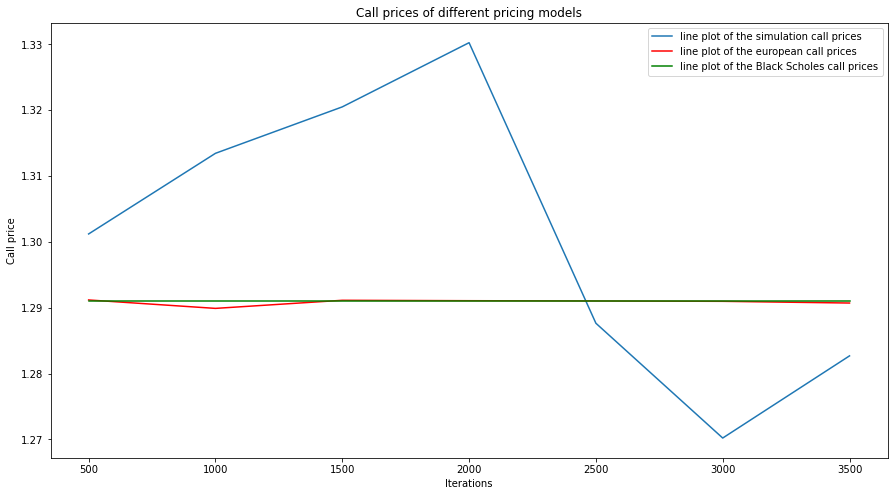

In [1830]:
#Finally I create a plot that shows the lines of the three models used to 
#calculate the call prices.
fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.plot(dfcp.Iterations.values,dfcp.Simulation_CP.values, 
       label='line plot of the simulation call prices')
ax.plot(dfcp.Iterations.values,dfcp.European_CP.values, color=('Red'),
       label='line plot of the european call prices')
ax.plot(dfcp.Iterations.values,dfcp.BlackScholes_CP.values, color=('Green'),
       label='line plot of the Black Scholes call prices')
ax.set_title('Call prices of different pricing models')
ax.set_xlabel('Iterations')
ax.set_ylabel('Call price')
ax.legend()
plt.show()

Here we can see that the simulated call prices revolve around the Black & Scholes call price. It also looks like the price deviates less from the Black and Scholes price when we get more Iterations. The european call prices also seem to revolve around the Black & Scholes call price but also deviates less as the Iterations increase. But it is a lot more accurate than our simulated price.